In [1]:
from neuralIncompleteFactorization.neuralif import models
from neuralIncompleteFactorization.apps import data
import matplotlib.pyplot as plt
from torch import nn
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import torch

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred whil

In [2]:
def generate_random_helmholtz(n, density=0.001):
    L = 1.0
    k = np.random.uniform(10, 200)  # Random wavenumber
    h = L / (n - 1)  

    # Discretization of Helmholtz operator (1D)
    diagonals = [np.ones(n-1), -2*np.ones(n), np.ones(n-1)]

    helmholtz = sp.diags(diagonals, [-1, 0, 1]) / h**2 + k**2 * sp.eye(n)

    # Ensure no perturbations on the tridiagnonal
    perturb = sp.random(n, n, density=density) * np.max(helmholtz)
    
    perturb.setdiag(0)  # Main diagonal
    perturb.setdiag(0, k=1)  # First upper diagonal
    perturb.setdiag(0, k=-1)  # First lower diagonal
        
    return helmholtz + perturb

In [3]:
kwargs = {
    "latent_size": 16, 
    "message_passing_steps": 4, 
    "skip_connections": 1,                  
    "augment_nodes": None, 
    "global_features": 4, 
    "decode_nodes": 4,                  
    "normalize_diag": True, 
    "activation": True, 
    "aggregate": None, 
    "graph_norm": None,
    "two_hop": None, 
    "edge_features": 4, 
    "normalize": None
}

model = models.NeuralPCG(**kwargs)

In [4]:
def normalize_features(graph_data):
    x_mean = graph_data.mean()
    x_std = graph_data.std()
    out = (graph_data - x_mean) / (x_std + 1e-12)
    return out.float()

def normalize_edge_attr(graph_data):
    e_mean = graph_data.mean()
    e_std = graph_data.std()
    out = (graph_data - e_mean) / (e_std + 1e-12)
    return out.float()

In [16]:
A = generate_random_helmholtz(500)
b = np.random.rand(500)
d = data.matrix_to_graph(A, b)
d.edge_attr = normalize_edge_attr(d.edge_attr)
d.x = normalize_features(d.x)

In [9]:
out = model(d)[0].to_dense().detach()

In [10]:
torch.linalg.det(out)

tensor(0.)

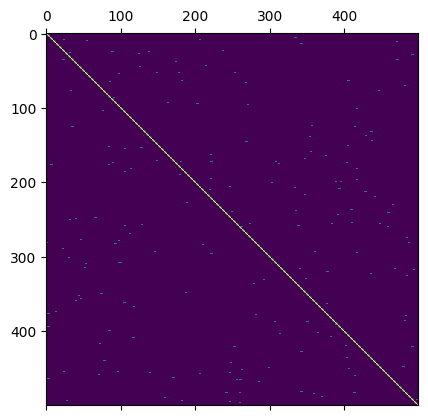

In [17]:
plt.matshow(model(d)[0].to_dense().detach())

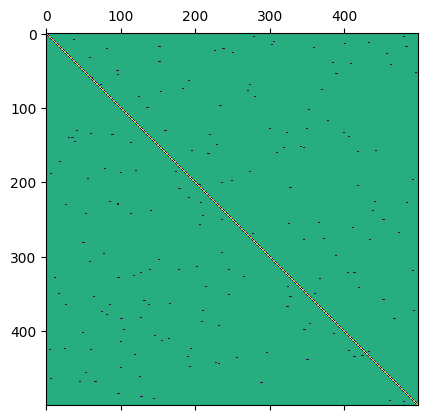

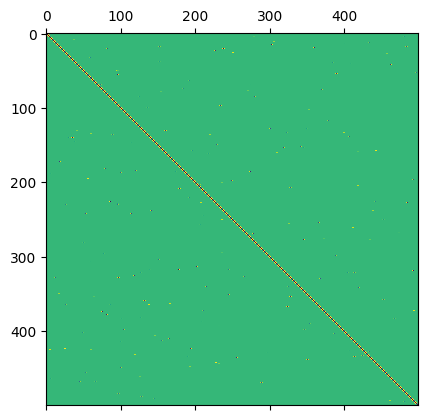

In [10]:
plt.matshow(model(d)[0].detach().to_dense())
plt.matshow(A.toarray())

In [19]:
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn.utils as nn_utils

In [45]:
def shared_training_loop(epoches, criterion, train_loader, valid_loader, model, lr, b=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, threshold=1e-3)

    train_log, valid_log = np.zeros(epoches), np.zeros(epoches)
    
    for epoch in range(epoches):
        
        train_loss = 0
        model.train()
        t_loader = tqdm(train_loader, desc=f'Train', leave=False, mininterval=2.0)
        for batch in t_loader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(batch, output[0].to_dense())

            t_loader.set_postfix(train_loss=loss.item())
            train_loss += loss.item()

            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            
        valid_loss = 0
        model.eval()
        v_loader = tqdm(valid_loader, desc=f'Valid', leave=False, mininterval=2.0)
        for batch in v_loader:
            with torch.no_grad():
                batch = batch.to(device)
                output = model(batch)
                loss = criterion(batch, output[0].to_dense())

                v_loader.set_postfix(valid_loss=loss.item())
                valid_loss += loss.item()
                
        print(f'Epoch: {epoch}, Train: {train_loss/len(t_loader)}, Valid: {valid_loss/len(v_loader)}')
        train_log[epoch], valid_log[epoch] = train_loss, valid_loss
        
        scheduler.step(valid_loss)
        
    return train_log, valid_log

In [58]:
class IdenittyDistance(nn.Module):
    def __init__(self, l1=None, logsum=None):
        super().__init__()
        self.l1 = l1
        self.logsum = logsum
        
    def forward(self, inp, outp):
        avg_loss = 0
        
        batch_size = inp.ptr.shape[0] - 1
        identity = torch.eye(500, device=inp.x.device).expand(batch_size, -1, -1)
        print(outp.shape)
        inner_product = torch.bmm(outp.view(batch_size, 500, 500), inp.x.view(batch_size, 500, 500))
        det = torch.mean(torch.abs(torch.linalg.det(inner_product))).item()
        
        # TODO : Pre-pre, idk man
        
        # Maximize the determinent | Minimize the condition number     
        if False and det < 1.0:
            slog_det = torch.log(torch.abs(torch.linalg.det(inner_product)))
            avg_loss += -torch.mean(slog_det) * 1.0
            
        else:
            #eye_frobenius_loss = torch.norm(inner_product - identity, p='fro', dim=(1, 2))
            #avg_loss += torch.mean(eye_frobenius_loss) * 1.0
        
            singular_values = torch.linalg.svdvals(inner_product)
            log_singular_values = torch.log(singular_values)
            log_cond = log_singular_values.max(dim=1).values - log_singular_values.min(dim=1).values
            avg_loss += torch.mean(log_cond) * 1.0
        
            if self.l1 is not None:
                avg_loss += self.l1 * torch.norm(outp, p=1) * 1.0
            elif self.logsum is not None:
                avg_loss += torch.sum(torch.log(1 + torch.abs(outp) / self.logsum))
        
        return avg_loss

In [59]:
class HelmHoltzDataset(Dataset):
    def __init__(self, generator, norm_feat, norm_edge, epoch_len, size=500, density=0.001, transform=None):
        super().__init__(None, transform)
        
        self.epoch_len = epoch_len
        self.mat_size = size
        self.mat_density = density
        
        self.generator = generator
        
        self.norm_features = norm_feat
        self.norm_edge_attr = norm_edge

    def len(self):
        return self.epoch_len

    def get(self, idx):
        A = generate_random_helmholtz(500)
        b = np.random.rand(500)
        d = data.matrix_to_graph(A, b)
        d.edge_attr = normalize_edge_attr(d.edge_attr)
        d.x = normalize_features(d.x)
        return d

In [60]:
dataset = HelmHoltzDataset(generate_random_helmholtz, normalize_features, normalize_edge_attr, 64*1000)
vdataset = HelmHoltzDataset(generate_random_helmholtz, normalize_features, normalize_edge_attr, 64*100)

In [61]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
vdataloader = DataLoader(vdataset, batch_size=64, shuffle=True)

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
shared_training_loop(10, IdenittyDistance(), dataloader, vdataloader, model.to(device), 1e-4)

Train:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([32000, 32000])


RuntimeError: shape '[64, 500, 500]' is invalid for input of size 1024000000